# HỆ THỐNG GỢI Ý SÁCH DỰA TRÊN ĐÁNH GIÁ NGƯỜI DÙNG

## IMPORT THƯ VIỆN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

### TẢI DỮ LIỆU

In [2]:
# Đọc file ratings
ratings = pd.read_csv(
    '/kaggle/input/books-dataset/books_data/ratings.csv',
    encoding='latin-1',
    sep=';',
    engine='python',
    on_bad_lines='skip'
)
print(f"Ratings dataset: {ratings.shape}")
print(f"Số dòng: {ratings.shape[0]:,}")
print(f"Số cột: {ratings.shape[1]}")
print("Mẫu dữ liệu ratings:")
print(ratings.head())



Ratings dataset: (1149766, 3)
Số dòng: 1,149,766
Số cột: 3
Mẫu dữ liệu ratings:
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6


In [3]:
# Đọc file books
books = pd.read_csv(
    '/kaggle/input/books-dataset/books_data/books.csv',
    encoding='latin-1',
    sep=';',
    engine='python',
    on_bad_lines='skip'
)

print(f"Books dataset: {books.shape}")
print(f"Số dòng: {books.shape[0]:,}")
print(f"Số cột: {books.shape[1]}")
print("Mẫu dữ liệu books:")
print(books.head())

Books dataset: (270491, 8)
Số dòng: 270,491
Số cột: 8
Mẫu dữ liệu books:
         ISBN                                         Book-Title           Book-Author  Year-Of-Publication                   Publisher                                        Image-URL-S                                        Image-URL-M                                        Image-URL-L
0  0195153448                                Classical Mythology    Mark P. O. Morford                 2002     Oxford University Press  http://images.amazon.com/images/P/0195153448.0...  http://images.amazon.com/images/P/0195153448.0...  http://images.amazon.com/images/P/0195153448.0...
1  0002005018                                       Clara Callan  Richard Bruce Wright                 2001       HarperFlamingo Canada  http://images.amazon.com/images/P/0002005018.0...  http://images.amazon.com/images/P/0002005018.0...  http://images.amazon.com/images/P/0002005018.0...
2  0060973129                               Decision in Norm

## KHÁM PHÁ DỮ LIỆU (EDA) - RATINGS
Phân tích thống kê dữ liệu ratings

In [4]:
print(ratings.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149766 entries, 0 to 1149765
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149766 non-null  int64 
 1   ISBN         1149766 non-null  object
 2   Book-Rating  1149766 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None


In [5]:
print(ratings.describe())

            User-ID   Book-Rating
count  1.149766e+06  1.149766e+06
mean   1.403862e+05  2.866906e+00
std    8.056191e+04  3.854172e+00
min    2.000000e+00  0.000000e+00
25%    7.034500e+04  0.000000e+00
50%    1.410100e+05  0.000000e+00
75%    2.110280e+05  7.000000e+00
max    2.788540e+05  1.000000e+01


In [6]:
# Kiểm tra giá trị null:
#print(ratings.isnull().sum())

In [7]:
# Phân bố đánh giá:
rating_dist = ratings['Book-Rating'].value_counts().sort_index()
print(rating_dist)

Book-Rating
0     716107
1       1770
2       2759
3       5996
4       8904
5      50973
6      36922
7      76454
8     103733
9      67540
10     78608
Name: count, dtype: int64


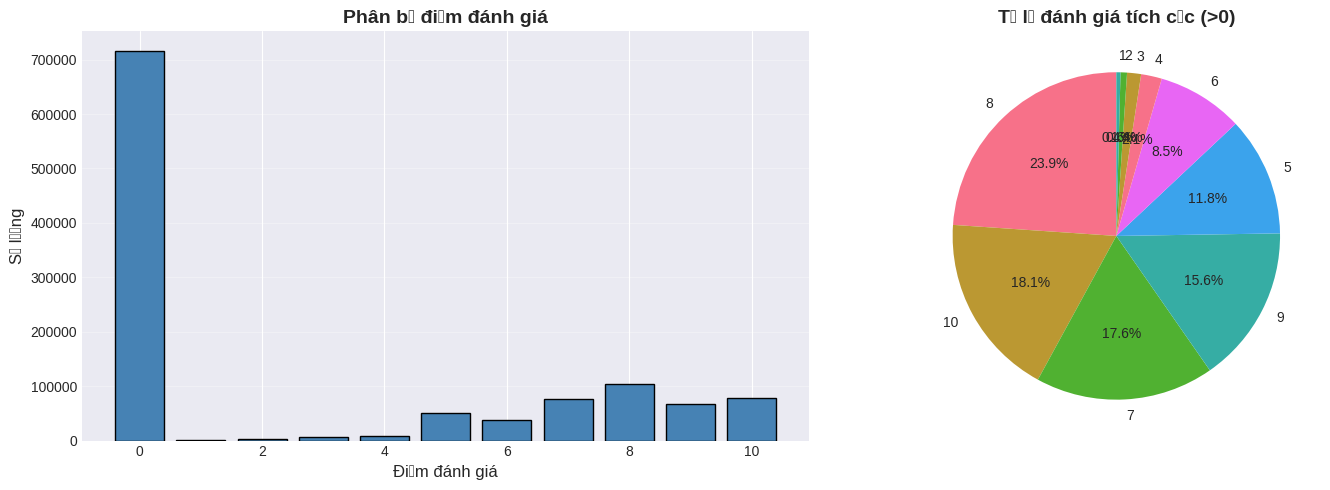

In [8]:
# Vẽ biểu đồ phân bố đánh giá
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Biểu đồ cột
axes[0].bar(rating_dist.index, rating_dist.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Điểm đánh giá', fontsize=12)
axes[0].set_ylabel('Số lượng', fontsize=12)
axes[0].set_title('Phân bố điểm đánh giá', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Biểu đồ tròn (chỉ đánh giá > 0)
positive_ratings = ratings[ratings['Book-Rating'] > 0]['Book-Rating'].value_counts()
axes[1].pie(positive_ratings.values, labels=positive_ratings.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Tỷ lệ đánh giá tích cực (>0)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## KHÁM PHÁ DỮ LIỆU (EDA) - BOOKS
Phân tích thống kê dữ liệu books

In [9]:
print(books.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270491 entries, 0 to 270490
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 270491 non-null  object
 1   Book-Title           270491 non-null  object
 2   Book-Author          270489 non-null  object
 3   Year-Of-Publication  270491 non-null  int64 
 4   Publisher            270489 non-null  object
 5   Image-URL-S          270491 non-null  object
 6   Image-URL-M          270491 non-null  object
 7   Image-URL-L          270491 non-null  object
dtypes: int64(1), object(7)
memory usage: 16.5+ MB
None


In [10]:
# Kiểm tra giá trị null:
print(books.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64


In [11]:
# Top 10 tác giả có nhiều sách nhất:
top_authors = books['Book-Author'].value_counts().head(10)
print(top_authors)

Book-Author
Agatha Christie        631
William Shakespeare    567
Stephen King           523
Ann M. Martin          423
Francine Pascal        372
Carolyn Keene          371
Isaac Asimov           329
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: count, dtype: int64


In [12]:
# Top 10 nhà xuất bản:
top_publishers = books['Publisher'].value_counts().head(10)
print(top_publishers)

Publisher
Harlequin                   7531
Silhouette                  4219
Pocket                      3894
Ballantine Books            3777
Bantam Books                3637
Scholastic                  3158
Simon &amp; Schuster        2963
Penguin Books               2839
Berkley Publishing Group    2767
Warner Books                2726
Name: count, dtype: int64


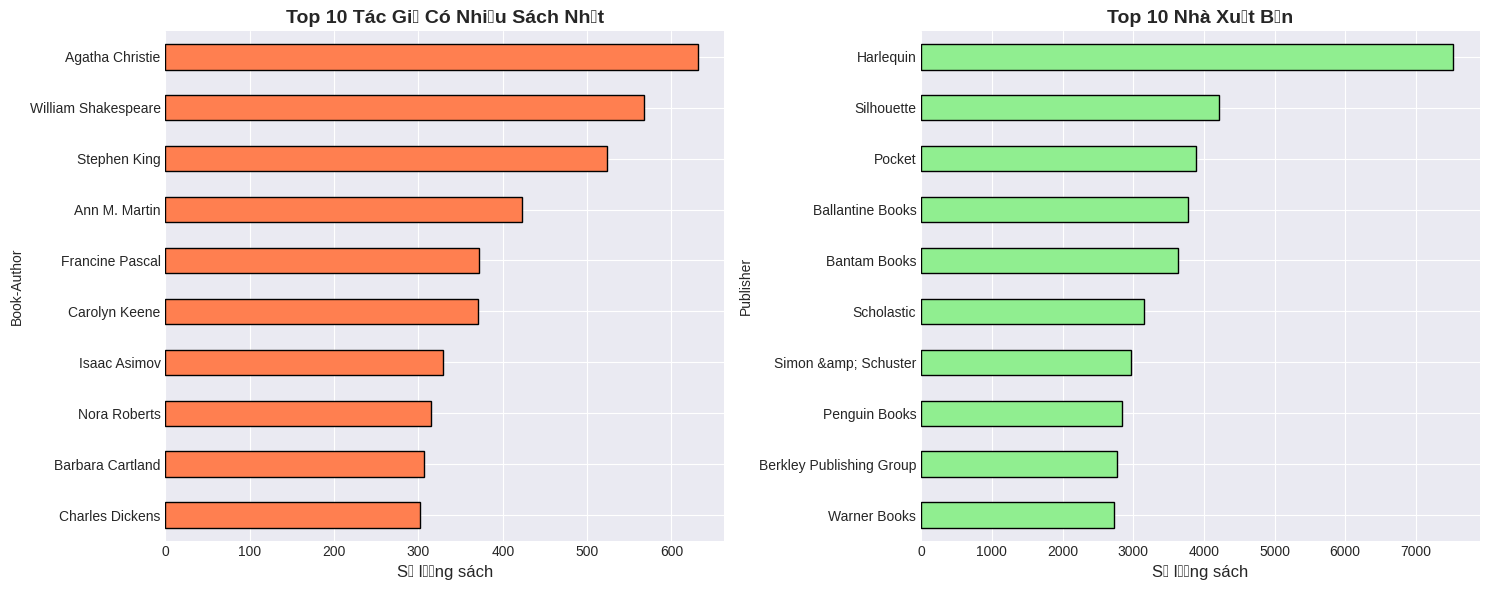

In [13]:
# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top tác giả
top_authors.plot(kind='barh', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_xlabel('Số lượng sách', fontsize=12)
axes[0].set_title('Top 10 Tác Giả Có Nhiều Sách Nhất', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Top nhà xuất bản
top_publishers.plot(kind='barh', ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Số lượng sách', fontsize=12)
axes[1].set_title('Top 10 Nhà Xuất Bản', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## TIỀN XỬ LÝ DỮ LIỆU - LỌC ĐÁNH GIÁ TÍCH CỰC
Lọc bỏ các đánh giá = 0 (implicit rating)

Chỉ giữ lại các đánh giá từ 1-10 (explicit rating)

### TIỀN XỬ LÝ DỮ LIỆU

In [14]:
print(f"Số lượng ratings ban đầu: {len(ratings):,}")

# Lọc ratings > 0
ratings_explicit = ratings[ratings['Book-Rating'] > 0].copy()
print(f"Số lượng ratings sau khi lọc (>0): {len(ratings_explicit):,}")
print(f"Đã loại bỏ: {len(ratings) - len(ratings_explicit):,} ratings = 0")

# Thống kê người dùng và sách
n_users = ratings_explicit['User-ID'].nunique()
n_books = ratings_explicit['ISBN'].nunique()
print(f"Số người dùng: {n_users:,}")
print(f"Số sách: {n_books:,}")
print(f"Tổng số đánh giá: {len(ratings_explicit):,}")
print(f"Mật độ ma trận: {len(ratings_explicit) / (n_users * n_books) * 100:.4f}%")


Số lượng ratings ban đầu: 1,149,766
Số lượng ratings sau khi lọc (>0): 433,659
Đã loại bỏ: 716,107 ratings = 0
Số người dùng: 77,797
Số sách: 185,963
Tổng số đánh giá: 433,659
Mật độ ma trận: 0.0030%


### LỌC NGƯỜI DÙNG VÀ SÁCH PHỔ BIẾN
Lọc người dùng có ít nhất 5 đánh giá

Lọc sách có ít nhất 5 đánh giá

Giảm sparsity của ma trận

In [15]:
# Đếm số đánh giá của mỗi user
user_counts = ratings_explicit['User-ID'].value_counts()
print(f"Phân bố số đánh giá của người dùng:")
print(user_counts.describe())

# Đếm số đánh giá của mỗi sách
book_counts = ratings_explicit['ISBN'].value_counts()
print(f"Phân bố số đánh giá của sách:")
print(book_counts.describe())

# Lọc người dùng có >= 5 đánh giá
min_user_ratings = 5
active_users = user_counts[user_counts >= min_user_ratings].index
ratings_filtered = ratings_explicit[ratings_explicit['User-ID'].isin(active_users)]
print(f"Lọc người dùng có >= {min_user_ratings} đánh giá:")
print(f"Số người dùng còn lại: {ratings_filtered['User-ID'].nunique():,}")
print(f"Số ratings còn lại: {len(ratings_filtered):,}")

# Lọc sách có >= 5 đánh giá
min_book_ratings = 5
popular_books = book_counts[book_counts >= min_book_ratings].index
ratings_filtered = ratings_filtered[ratings_filtered['ISBN'].isin(popular_books)]
print(f"Lọc sách có >= {min_book_ratings} đánh giá:")
print(f"Số sách còn lại: {ratings_filtered['ISBN'].nunique():,}")
print(f"Số ratings còn lại: {len(ratings_filtered):,}")

# Tính mật độ mới
n_users_filtered = ratings_filtered['User-ID'].nunique()
n_books_filtered = ratings_filtered['ISBN'].nunique()
density = len(ratings_filtered) / (n_users_filtered * n_books_filtered) * 100
print(f"Mật độ ma trận sau lọc: {density:.4f}%")

Phân bố số đánh giá của người dùng:
count    77797.000000
mean         5.574238
std         43.999086
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       8522.000000
Name: count, dtype: float64
Phân bố số đánh giá của sách:
count    185963.000000
mean          2.331964
std           6.834845
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         707.000000
Name: count, dtype: float64
Lọc người dùng có >= 5 đánh giá:
Số người dùng còn lại: 14,220
Số ratings còn lại: 340,337
Lọc sách có >= 5 đánh giá:
Số sách còn lại: 14,513
Số ratings còn lại: 152,280
Mật độ ma trận sau lọc: 0.0789%


###  TẠO MA TRẬN USER-ITEM
Tạo ma trận User-Item dạng pivot table

Rows: Users, Columns: Books, Values: Ratings

In [16]:
# Tạo pivot table
user_item_matrix = ratings_filtered.pivot_table(
    index='User-ID', 
    columns='ISBN', 
    values='Book-Rating',
    fill_value=0
)

print(f"Kích thước ma trận User-Item: {user_item_matrix.shape}")
print(f"Số người dùng (rows): {user_item_matrix.shape[0]:,}")
print(f"Số sách (columns): {user_item_matrix.shape[1]:,}")
print(f"Tổng số phần tử: {user_item_matrix.shape[0] * user_item_matrix.shape[1]:,}")

print("Mẫu ma trận User-Item (5 users x 5 books):")
print(user_item_matrix.iloc[:5, :5])

# Chuyển sang sparse matrix để tiết kiệm bộ nhớ
user_item_sparse = csr_matrix(user_item_matrix.values)
print(f"Kích thước sparse matrix: {user_item_sparse.shape}")
print(f"Non-zero elements: {user_item_sparse.nnz:,}")
print(f"Sparsity: {(1 - user_item_sparse.nnz / (user_item_sparse.shape[0] * user_item_sparse.shape[1])) * 100:.2f}%")


Kích thước ma trận User-Item: (13305, 14513)
Số người dùng (rows): 13,305
Số sách (columns): 14,513
Tổng số phần tử: 193,095,465
Mẫu ma trận User-Item (5 users x 5 books):
ISBN     0000000000  0002005018  0002251760  0002259001  0002259834
User-ID                                                            
8               0.0         5.0         0.0         0.0         0.0
99              0.0         0.0         0.0         0.0         0.0
114             0.0         0.0         0.0         0.0         0.0
232             0.0         0.0         0.0         0.0         0.0
242             0.0         0.0         0.0         0.0         0.0
Kích thước sparse matrix: (13305, 14513)
Non-zero elements: 152,280
Sparsity: 99.92%


### CHIA TẬP TRAIN/TEST
Chia dữ liệu thành tập train (80%) và test (20%)

In [17]:
# Chia dữ liệu
train_data, test_data = train_test_split(ratings_filtered, test_size=0.2, random_state=42)

print(f"Kích thước tập dữ liệu:")
print(f"Train set: {len(train_data):,} ratings ({len(train_data)/len(ratings_filtered)*100:.1f}%)")
print(f"Test set: {len(test_data):,} ratings ({len(test_data)/len(ratings_filtered)*100:.1f}%)")

# Tạo ma trận train
train_matrix = train_data.pivot_table(
    index='User-ID',
    columns='ISBN',
    values='Book-Rating',
    fill_value=0
)

print(f"Ma trận train: {train_matrix.shape}")

Kích thước tập dữ liệu:
Train set: 121,824 ratings (80.0%)
Test set: 30,456 ratings (20.0%)
Ma trận train: (13008, 14472)


### MÔ HÌNH 1 - USER-BASED COLLABORATIVE FILTERING (KNN)

- Tìm người dùng tương tự dựa trên cosine similarity

- Sử dụng K-Nearest Neighbors

- Gợi ý sách dựa trên sở thích của người dùng tương tự

In [18]:
# Khởi tạo mô hình KNN
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model_knn.fit(train_matrix)

print("Đã huấn luyện mô hình KNN User-Based")
print(f"   - Metric: Cosine Similarity")
print(f"   - Số neighbors: 20")
print(f"   - Algorithm: Brute Force")

# Hàm gợi ý sách cho user
def recommend_books_knn(user_id, n_recommendations=10):
    """
    Gợi ý sách cho user bằng KNN User-Based
    """
    if user_id not in train_matrix.index:
        return None
    
    # Lấy vector của user
    user_vector = train_matrix.loc[user_id].values.reshape(1, -1)
    
    # Tìm K nearest neighbors
    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=21)
    
    # Bỏ user chính (index 0)
    similar_users = train_matrix.iloc[indices.flatten()[1:]].index
    
    # Lấy sách mà user chưa đánh giá
    user_rated_books = set(ratings_filtered[ratings_filtered['User-ID'] == user_id]['ISBN'])
    
    # Tính điểm cho các sách dựa trên similar users
    book_scores = {}
    for similar_user in similar_users:
        similar_user_ratings = ratings_filtered[ratings_filtered['User-ID'] == similar_user]
        for _, row in similar_user_ratings.iterrows():
            if row['ISBN'] not in user_rated_books:
                if row['ISBN'] not in book_scores:
                    book_scores[row['ISBN']] = []
                book_scores[row['ISBN']].append(row['Book-Rating'])
    
    # Tính trung bình điểm
    book_avg_scores = {book: np.mean(scores) for book, scores in book_scores.items()}
    
    # Sắp xếp và lấy top N
    top_books = sorted(book_avg_scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    
    # Lấy thông tin sách
    recommendations = []
    for isbn, score in top_books:
        book_info = books[books['ISBN'] == isbn]
        if not book_info.empty:
            recommendations.append({
                'ISBN': isbn,
                'Title': book_info.iloc[0]['Book-Title'],
                'Author': book_info.iloc[0]['Book-Author'],
                'Predicted_Rating': round(score, 2)
            })
    
    return pd.DataFrame(recommendations)

# Test mô hình với 1 user
sample_user = train_matrix.index[0]
print(f"Gợi ý sách cho User ID: {sample_user}")
recommendations_knn = recommend_books_knn(sample_user, n_recommendations=10)
if recommendations_knn is not None:
    print(recommendations_knn)

Đã huấn luyện mô hình KNN User-Based
   - Metric: Cosine Similarity
   - Số neighbors: 20
   - Algorithm: Brute Force
Gợi ý sách cho User ID: 8
         ISBN                                              Title              Author  Predicted_Rating
0  0446310786                              To Kill a Mockingbird          Harper Lee              10.0
1  0060005424                      Lirael: Daughter of the Clayr           Garth Nix              10.0
2  0060083263                Sleeping Beauty (Margolin, Phillip)    Phillip Margolin              10.0
3  0060175400                               The Poisonwood Bible  Barbara Kingsolver              10.0
4  0060192119  As Nature Made Him: The Boy Who Was Raised As ...      John Colapinto              10.0
5  006019250X  The Illustrated Alchemist: A Fable About Follo...        Paulo Coelho              10.0
6  006019491X  Daughter of Fortune : A Novel (Oprah's Book Cl...      Isabel Allende              10.0
7  0060195703                   

### MÔ HÌNH 2 - ITEM-BASED COLLABORATIVE FILTERING
- Tính similarity giữa các sách
  
- Gợi ý sách tương tự với sách user đã thích

In [19]:
# Tạo ma trận item-item (transpose của user-item)
item_user_matrix = train_matrix.T

# Tính cosine similarity giữa các sách
item_similarity = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=train_matrix.columns,
    columns=train_matrix.columns
)

print(f"Đã tính toán Item Similarity Matrix")
print(f"Kích thước: {item_similarity_df.shape}")
print(f"Metric: Cosine Similarity")

# Hàm gợi ý sách dựa trên item similarity
def recommend_books_item_based(user_id, n_recommendations=10):
    """
    Gợi ý sách dựa trên Item-Based CF
    """
    if user_id not in train_matrix.index:
        return None
    
    # Lấy các sách user đã đánh giá cao (>= 7)
    user_ratings = ratings_filtered[
        (ratings_filtered['User-ID'] == user_id) & 
        (ratings_filtered['Book-Rating'] >= 7)
    ]
    
    if user_ratings.empty:
        return None
    
    # Tìm sách tương tự
    similar_books_scores = {}
    for isbn in user_ratings['ISBN']:
        if isbn in item_similarity_df.index:
            similar_books = item_similarity_df[isbn].sort_values(ascending=False)[1:51]
            for similar_isbn, similarity_score in similar_books.items():
                if similar_isbn not in user_ratings['ISBN'].values:
                    if similar_isbn not in similar_books_scores:
                        similar_books_scores[similar_isbn] = []
                    similar_books_scores[similar_isbn].append(similarity_score)
    
    # Tính trung bình similarity
    book_avg_similarity = {book: np.mean(scores) for book, scores in similar_books_scores.items()}
    
    # Lấy top N
    top_books = sorted(book_avg_similarity.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    
    # Lấy thông tin sách
    recommendations = []
    for isbn, similarity in top_books:
        book_info = books[books['ISBN'] == isbn]
        if not book_info.empty:
            recommendations.append({
                'ISBN': isbn,
                'Title': book_info.iloc[0]['Book-Title'],
                'Author': book_info.iloc[0]['Book-Author'],
                'Similarity_Score': round(similarity, 4)
            })
    
    return pd.DataFrame(recommendations)

# Test mô hình
print(f"Gợi ý sách cho User ID: {sample_user}")
recommendations_item = recommend_books_item_based(sample_user, n_recommendations=10)
if recommendations_item is not None:
    print(recommendations_item)

Đã tính toán Item Similarity Matrix
Kích thước: (14472, 14472)
Metric: Cosine Similarity
Gợi ý sách cho User ID: 8


### MÔ HÌNH 3 - MATRIX FACTORIZATION (SVD)
- Phân rã ma trận thành latent factors
  
- Giảm chiều dữ liệu
  
- Dự đoán ratings cho các item chưa được đánh giá

In [20]:
# Khởi tạo SVD
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)

# Fit model
train_matrix_sparse = csr_matrix(train_matrix.values)
matrix_factorized = svd.fit_transform(train_matrix_sparse)

print(f"Đã huấn luyện mô hình SVD")
print(f"Số components: {n_components}")
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

# Tái tạo ma trận
predicted_ratings = np.dot(matrix_factorized, svd.components_)
predicted_ratings_df = pd.DataFrame(
    predicted_ratings,
    index=train_matrix.index,
    columns=train_matrix.columns
)

print(f"Ma trận dự đoán: {predicted_ratings_df.shape}")

# Hàm gợi ý sách bằng SVD
def recommend_books_svd(user_id, n_recommendations=10):
    """
    Gợi ý sách dựa trên Matrix Factorization (SVD)
    """
    if user_id not in predicted_ratings_df.index:
        return None
    
    # Lấy predictions cho user
    user_predictions = predicted_ratings_df.loc[user_id]
    
    # Lấy sách user chưa đánh giá
    user_rated_books = set(ratings_filtered[ratings_filtered['User-ID'] == user_id]['ISBN'])
    
    # Lọc và sắp xếp
    unrated_predictions = user_predictions[~user_predictions.index.isin(user_rated_books)]
    top_books = unrated_predictions.sort_values(ascending=False)[:n_recommendations]
    
    # Lấy thông tin sách
    recommendations = []
    for isbn, predicted_rating in top_books.items():
        book_info = books[books['ISBN'] == isbn]
        if not book_info.empty:
            recommendations.append({
                'ISBN': isbn,
                'Title': book_info.iloc[0]['Book-Title'],
                'Author': book_info.iloc[0]['Book-Author'],
                'Predicted_Rating': round(predicted_rating, 2)
            })
    
    return pd.DataFrame(recommendations)

# Test mô hình
print(f"Gợi ý sách cho User ID: {sample_user}")
recommendations_svd = recommend_books_svd(sample_user, n_recommendations=10)
if recommendations_svd is not None:
    print(recommendations_svd)

Đã huấn luyện mô hình SVD
Số components: 50
Explained variance ratio: 0.1302
Ma trận dự đoán: (13008, 14472)
Gợi ý sách cho User ID: 8
         ISBN                                              Title             Author  Predicted_Rating
0  0446310786                              To Kill a Mockingbird         Harper Lee              0.01
1  067976402X                             Snow Falling on Cedars     David Guterson              0.01
2  0786868716                 The Five People You Meet in Heaven        Mitch Albom              0.01
3  0385484518  Tuesdays with Morrie: An Old Man, a Young Man,...        MITCH ALBOM              0.01
4  0671003755  She's Come Undone (Oprah's Book Club (Paperback))         Wally Lamb              0.01
5  0060938455  Fast Food Nation: The Dark Side of the All-Ame...     Eric Schlosser              0.01
6  0452282829                              We Were the Mulvaneys  Joyce Carol Oates              0.00
7  0375706771                                  Mi

### MÔ HÌNH 4 - POPULARITY-BASED RECOMMENDATION
- Gợi ý sách phổ biến nhất (nhiều đánh giá cao nhất)
  
- Baseline model đơn giản
  
- Không cá nhân hóa

In [21]:
# Tính điểm phổ biến cho mỗi sách
book_stats = ratings_filtered.groupby('ISBN').agg({
    'Book-Rating': ['mean', 'count']
}).reset_index()
book_stats.columns = ['ISBN', 'avg_rating', 'num_ratings']

# Lọc sách có ít nhất 10 đánh giá
popular_books = book_stats[book_stats['num_ratings'] >= 10].copy()

# Tính popularity score (weighted rating)
C = popular_books['avg_rating'].mean()
m = popular_books['num_ratings'].quantile(0.7)

def weighted_rating(x, m=m, C=C):
    v = x['num_ratings']
    R = x['avg_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

popular_books['popularity_score'] = popular_books.apply(weighted_rating, axis=1)
popular_books = popular_books.sort_values('popularity_score', ascending=False)

# Merge với thông tin sách
popular_books_info = popular_books.merge(books[['ISBN', 'Book-Title', 'Book-Author']], on='ISBN', how='left')

print(f"Đã tính toán Popularity Score")
print(f"Công thức: Weighted Rating (IMDB formula)")
print(f"Số sách đủ điều kiện: {len(popular_books):,}")

print(f"Top 10 sách phổ biến nhất:")
print(popular_books_info[['ISBN', 'Book-Title', 'Book-Author', 'avg_rating', 'num_ratings', 'popularity_score']].head(10))

Đã tính toán Popularity Score
Công thức: Weighted Rating (IMDB formula)
Số sách đủ điều kiện: 4,136
Top 10 sách phổ biến nhất:
         ISBN                                         Book-Title     Book-Author  avg_rating  num_ratings  popularity_score
0  0439139597       Harry Potter and the Goblet of Fire (Book 4)   J. K. Rowling    9.305085          118          9.066593
1  0345339738  The Return of the King (The Lord of the Rings,...  J.R.R. TOLKIEN    9.411765           68          9.014701
2  043935806X  Harry Potter and the Order of the Phoenix (Boo...   J. K. Rowling    9.071006          169          8.923157
3  0446310786                              To Kill a Mockingbird      Harper Lee    9.045455          154          8.888199
4  0439136350  Harry Potter and the Prisoner of Azkaban (Book 3)   J. K. Rowling    9.081967          122          8.884188
5  059035342X  Harry Potter and the Sorcerer's Stone (Harry P...   J. K. Rowling    8.986784          227          8.880816
6  03

### ĐÁNH GIÁ MÔ HÌNH - TÍNH RMSE VÀ MAE
Đánh giá các mô hình trên tập test

Tính RMSE và MAE

In [22]:
# Chuẩn bị test data
test_predictions = []
test_actuals = []

# Lấy mẫu từ test set để đánh giá (100 samples)
test_sample = test_data.sample(min(100, len(test_data)), random_state=42)

print(f"Đánh giá trên {len(test_sample)} samples từ test set")

# Đánh giá SVD model
print("Đang đánh giá mô hình SVD...")
for _, row in test_sample.iterrows():
    user_id = row['User-ID']
    isbn = row['ISBN']
    actual_rating = row['Book-Rating']
    
    if user_id in predicted_ratings_df.index and isbn in predicted_ratings_df.columns:
        predicted_rating = predicted_ratings_df.loc[user_id, isbn]
        test_predictions.append(predicted_rating)
        test_actuals.append(actual_rating)

if len(test_predictions) > 0:
    rmse_svd = np.sqrt(mean_squared_error(test_actuals, test_predictions))
    mae_svd = mean_absolute_error(test_actuals, test_predictions)
    
    print(f"Kết quả đánh giá SVD Model:")
    print(f"   - RMSE: {rmse_svd:.4f}")
    print(f"   - MAE: {mae_svd:.4f}")
    print(f"   - Số predictions: {len(test_predictions)}")
else:
    print("Không đủ dữ liệu để đánh giá SVD model")

# Đánh giá Popularity-Based
print("Đánh giá mô hình Popularity-Based...")
popularity_predictions = []
popularity_actuals = []

avg_popularity_score = popular_books['popularity_score'].mean()

for _, row in test_sample.iterrows():
    isbn = row['ISBN']
    actual_rating = row['Book-Rating']
    
    book_pop = popular_books[popular_books['ISBN'] == isbn]
    if not book_pop.empty:
        predicted_rating = book_pop.iloc[0]['popularity_score']
    else:
        predicted_rating = avg_popularity_score
    
    # Scale về 1-10
    predicted_rating = min(10, max(1, predicted_rating))
    
    popularity_predictions.append(predicted_rating)
    popularity_actuals.append(actual_rating)

rmse_popularity = np.sqrt(mean_squared_error(popularity_actuals, popularity_predictions))
mae_popularity = mean_absolute_error(popularity_actuals, popularity_predictions)

print(f"Kết quả đánh giá Popularity Model:")
print(f"RMSE: {rmse_popularity:.4f}")
print(f"MAE: {mae_popularity:.4f}")

Đánh giá trên 100 samples từ test set
Đang đánh giá mô hình SVD...
Kết quả đánh giá SVD Model:
   - RMSE: 7.8967
   - MAE: 7.6771
   - Số predictions: 99
Đánh giá mô hình Popularity-Based...
Kết quả đánh giá Popularity Model:
RMSE: 1.8113
MAE: 1.3867


### SO SÁNH CÁC MÔ HÌNH
Tổng hợp và so sánh kết quả các mô hình

Bảng so sánh các mô hình:
                   Mô hình     RMSE      MAE                                 Ưu điểm                                Nhược điểm
SVD (Matrix Factorization) 7.896657 7.677065     Cá nhân hóa cao, xử lý sparsity tốt Yêu cầu nhiều dữ liệu, tính toán phức tạp
          Popularity-Based 1.811328 1.386733 Đơn giản, nhanh, không cần dữ liệu user     Không cá nhân hóa, cold-start problem


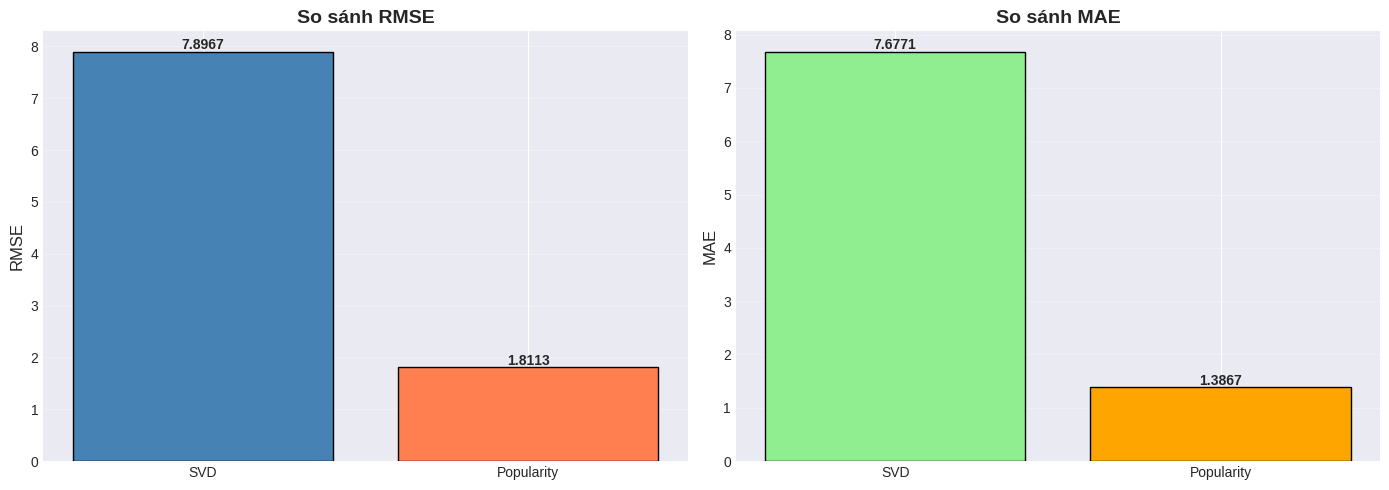

In [23]:
# Tạo bảng so sánh
comparison_data = {
    'Mô hình': ['SVD (Matrix Factorization)', 'Popularity-Based'],
    'RMSE': [rmse_svd if len(test_predictions) > 0 else 'N/A', rmse_popularity],
    'MAE': [mae_svd if len(test_predictions) > 0 else 'N/A', mae_popularity],
    'Ưu điểm': [
        'Cá nhân hóa cao, xử lý sparsity tốt',
        'Đơn giản, nhanh, không cần dữ liệu user'
    ],
    'Nhược điểm': [
        'Yêu cầu nhiều dữ liệu, tính toán phức tạp',
        'Không cá nhân hóa, cold-start problem'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("Bảng so sánh các mô hình:")
print(comparison_df.to_string(index=False))

# Vẽ biểu đồ so sánh
if len(test_predictions) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    models = ['SVD', 'Popularity']
    rmse_scores = [rmse_svd, rmse_popularity]
    mae_scores = [mae_svd, mae_popularity]
    
    # RMSE comparison
    axes[0].bar(models, rmse_scores, color=['steelblue', 'coral'], edgecolor='black')
    axes[0].set_ylabel('RMSE', fontsize=12)
    axes[0].set_title('So sánh RMSE', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(rmse_scores):
        axes[0].text(i, v + 0.05, f'{v:.4f}', ha='center', fontweight='bold')
    
    # MAE comparison
    axes[1].bar(models, mae_scores, color=['lightgreen', 'orange'], edgecolor='black')
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('So sánh MAE', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(mae_scores):
        axes[1].text(i, v + 0.05, f'{v:.4f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

### DEMO HỆ THỐNG GỢI Ý
Demo hệ thống gợi ý cho 1 user cụ thể

Hiển thị kết quả từ tất cả các mô hình

In [24]:
# Chọn 1 user ngẫu nhiên
demo_user = train_matrix.index[np.random.randint(0, len(train_matrix))]

print(f"Demo gợi ý cho User ID: {demo_user}")

# Hiển thị lịch sử đánh giá của user
user_history = ratings_filtered[ratings_filtered['User-ID'] == demo_user].sort_values('Book-Rating', ascending=False)
user_history_with_info = user_history.merge(books[['ISBN', 'Book-Title', 'Book-Author']], on='ISBN', how='left')

print(f"Lịch sử đánh giá của user ({len(user_history)} sách):")
print(user_history_with_info[['Book-Title', 'Book-Author', 'Book-Rating']].head(10))

print("GỢI Ý TỪ CÁC MÔ HÌNH")

# Model 1: User-Based CF
print("Mô hình 1: User-Based Collaborative Filtering (KNN)")
rec_knn = recommend_books_knn(demo_user, 5)
if rec_knn is not None:
    print(rec_knn.to_string(index=False))
else:
    print("Không có gợi ý")

# Model 2: Item-Based CF
print("Mô hình 2: Item-Based Collaborative Filtering")
rec_item = recommend_books_item_based(demo_user, 5)
if rec_item is not None:
    print(rec_item.to_string(index=False))
else:
    print("Không có gợi ý")

# Model 3: SVD
print("Mô hình 3: Matrix Factorization (SVD)")
rec_svd = recommend_books_svd(demo_user, 5)
if rec_svd is not None:
    print(rec_svd.to_string(index=False))
else:
    print("Không có gợi ý")

# Model 4: Popularity
print("Mô hình 4: Popularity-Based")
print(popular_books_info[['Book-Title', 'Book-Author', 'avg_rating', 'num_ratings', 'popularity_score']].head(5).to_string(index=False))

Demo gợi ý cho User ID: 92696
Lịch sử đánh giá của user (7 sách):
                                          Book-Title      Book-Author  Book-Rating
0                  Out to Canaan (The Mitford Years)        Jan Karon           10
1          A Light in the Window (The Mitford Years)        Jan Karon            9
2  How the Irish Saved Civilization: The Untold S...    Thomas Cahill            8
3                                            Frindle  Andrew Clements            8
4                                 Wish You Were Here    Stewart O'Nan            8
5   The Hungry Ocean : A Swordboat Captain's Journey   Linda Greenlaw            7
6  The Country Ahead of Us, The Country Behind (V...   DAVID GUTERSON            5
GỢI Ý TỪ CÁC MÔ HÌNH
Mô hình 1: User-Based Collaborative Filtering (KNN)
      ISBN                                                     Title                  Author  Predicted_Rating
030700645X                     Eeyore, Be Happy (Little Golden Book)            Don Fe

### PHÂN TÍCH DIVERSITY VÀ COVERAGE
Phân tích độ đa dạng và độ bao phủ của các mô hình

Catalog Coverage (50 users, 10 recommendations each):
User-Based CF (KNN): 2.92% (424 sách khác nhau)
SVD: 1.24% (180 sách khác nhau)


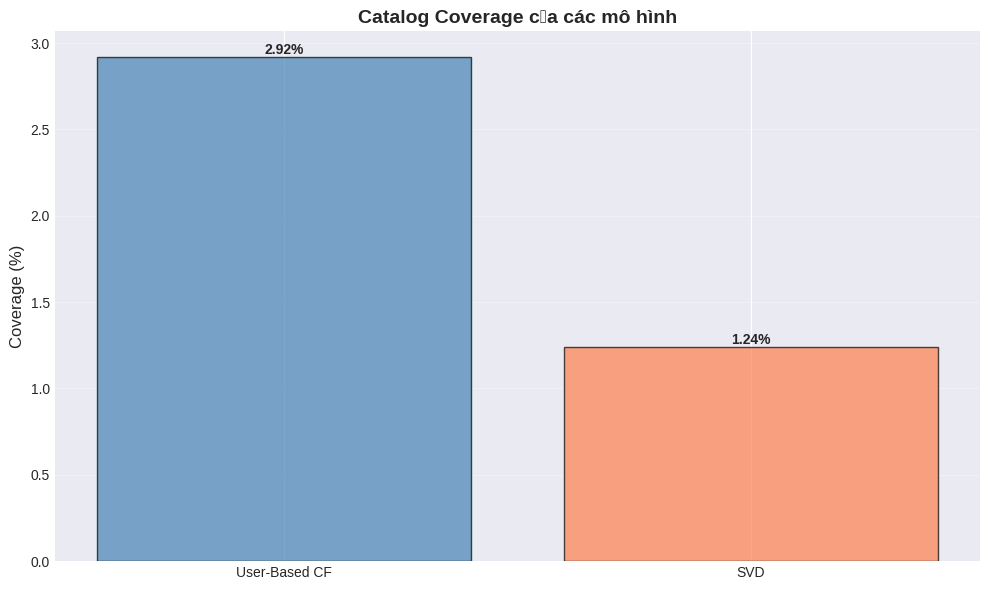

In [25]:
# Tính catalog coverage
total_books = ratings_filtered['ISBN'].nunique()

# Lấy gợi ý cho nhiều users
sample_users = train_matrix.index[:50]  # 50 users
recommended_books_knn = set()
recommended_books_svd = set()

for user in sample_users:
    # KNN
    rec = recommend_books_knn(user, 10)
    if rec is not None:
        recommended_books_knn.update(rec['ISBN'].tolist())
    
    # SVD
    rec = recommend_books_svd(user, 10)
    if rec is not None:
        recommended_books_svd.update(rec['ISBN'].tolist())

coverage_knn = len(recommended_books_knn) / total_books * 100
coverage_svd = len(recommended_books_svd) / total_books * 100

print(f"Catalog Coverage (50 users, 10 recommendations each):")
print(f"User-Based CF (KNN): {coverage_knn:.2f}% ({len(recommended_books_knn)} sách khác nhau)")
print(f"SVD: {coverage_svd:.2f}% ({len(recommended_books_svd)} sách khác nhau)")

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(10, 6))
models = ['User-Based CF', 'SVD']
coverage = [coverage_knn, coverage_svd]
colors = ['steelblue', 'coral']

bars = ax.bar(models, coverage, color=colors, edgecolor='black', alpha=0.7)
ax.set_ylabel('Coverage (%)', fontsize=12)
ax.set_title('Catalog Coverage của các mô hình', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

 ### PHÂN TÍCH COLD START PROBLEM
 Phân tích vấn đề Cold Start

In [26]:
# Tìm users có ít đánh giá nhất
user_rating_counts = ratings_filtered['User-ID'].value_counts()
cold_start_users = user_rating_counts[user_rating_counts <= 10].index[:5]

print(f"Phân tích Cold Start Users (có <= 10 đánh giá):")

for user in cold_start_users:
    n_ratings = user_rating_counts[user]
    print(f"User {user} - {n_ratings} đánh giá:")
    
    # Thử gợi ý bằng các mô hình
    can_recommend_knn = user in train_matrix.index
    can_recommend_svd = user in predicted_ratings_df.index
    
    print(f"   - User-Based CF: {'Có thể gợi ý' if can_recommend_knn else 'Không thể gợi ý'}")
    print(f"   - SVD: {'Có thể gợi ý' if can_recommend_svd else 'Không thể gợi ý'}")
    print(f"   - Popularity: Có thể gợi ý (không phụ thuộc user)")

Phân tích Cold Start Users (có <= 10 đánh giá):
User 125217 - 10 đánh giá:
   - User-Based CF: Có thể gợi ý
   - SVD: Có thể gợi ý
   - Popularity: Có thể gợi ý (không phụ thuộc user)
User 239070 - 10 đánh giá:
   - User-Based CF: Có thể gợi ý
   - SVD: Có thể gợi ý
   - Popularity: Có thể gợi ý (không phụ thuộc user)
User 150762 - 10 đánh giá:
   - User-Based CF: Có thể gợi ý
   - SVD: Có thể gợi ý
   - Popularity: Có thể gợi ý (không phụ thuộc user)
User 240318 - 10 đánh giá:
   - User-Based CF: Có thể gợi ý
   - SVD: Có thể gợi ý
   - Popularity: Có thể gợi ý (không phụ thuộc user)
User 24525 - 10 đánh giá:
   - User-Based CF: Có thể gợi ý
   - SVD: Có thể gợi ý
   - Popularity: Có thể gợi ý (không phụ thuộc user)


### VISUALIZATION - PHÂN BỐ RATINGS
Trực quan hóa các phân tích quan trọng

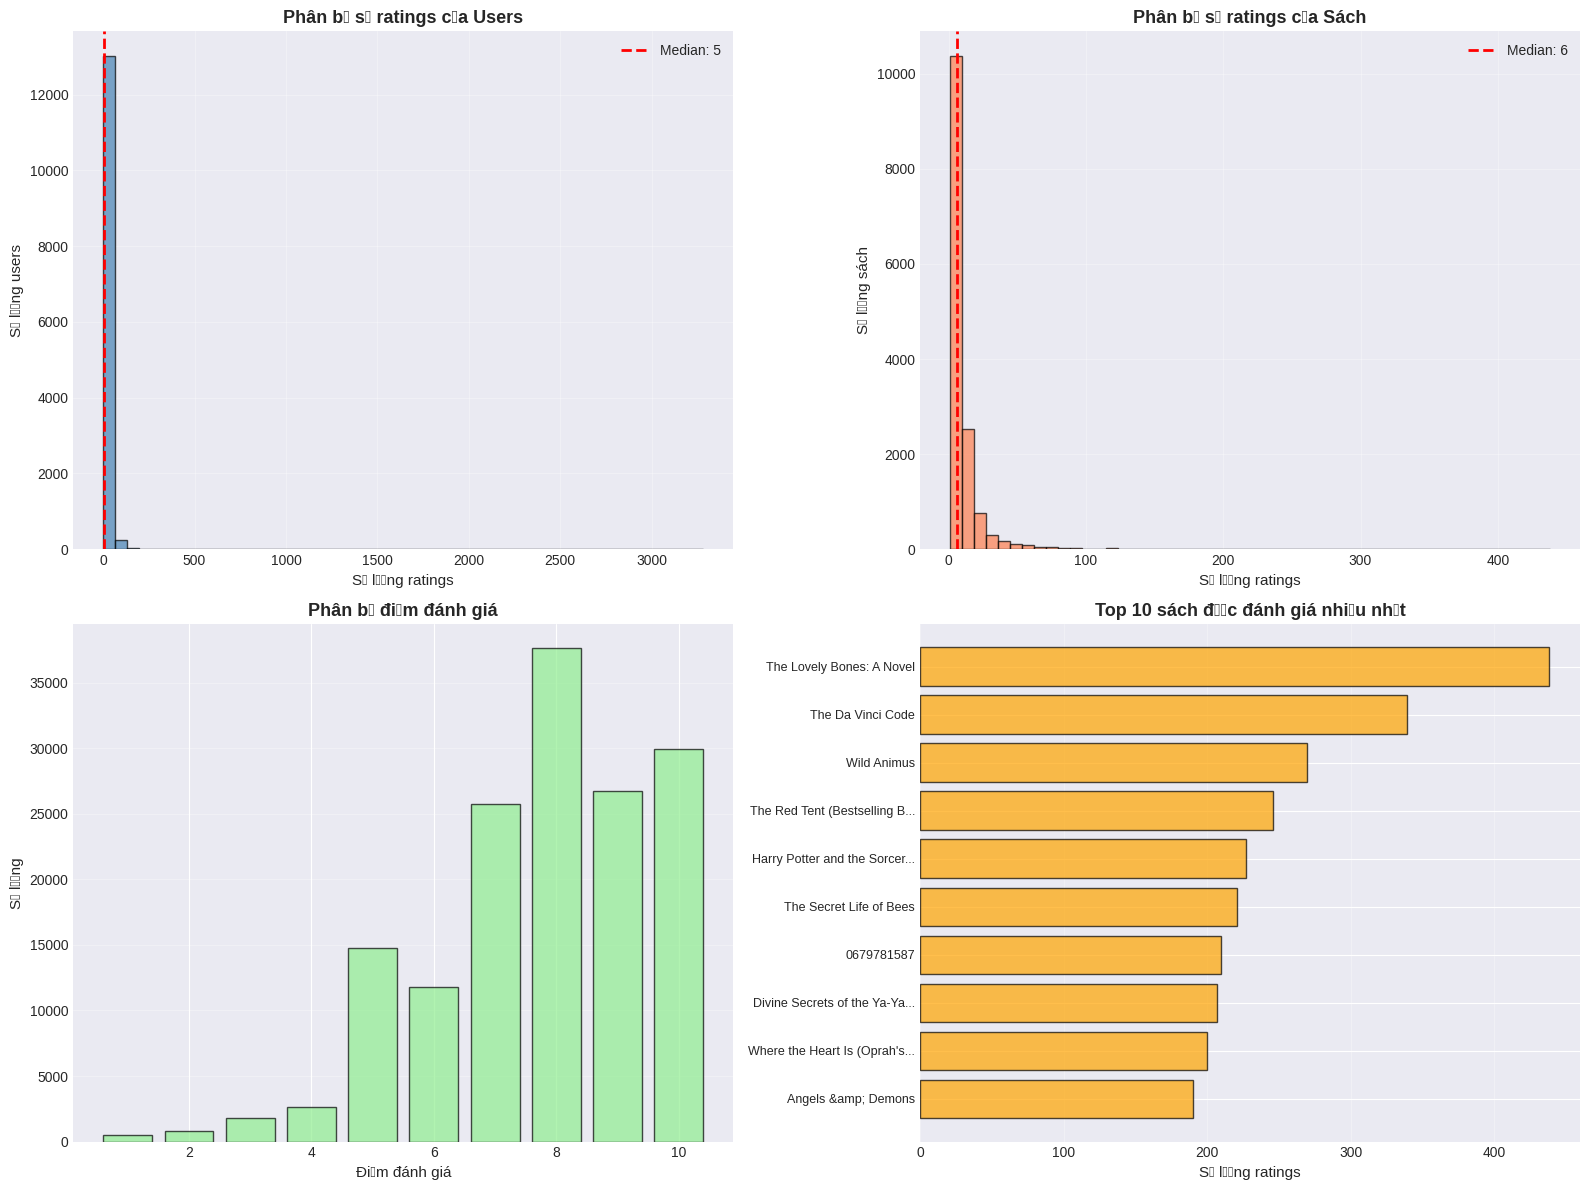

In [27]:
ig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Phân bố số lượng ratings của users
user_rating_dist = ratings_filtered['User-ID'].value_counts()
axes[0, 0].hist(user_rating_dist.values, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Số lượng ratings', fontsize=11)
axes[0, 0].set_ylabel('Số lượng users', fontsize=11)
axes[0, 0].set_title('Phân bố số ratings của Users', fontsize=13, fontweight='bold')
axes[0, 0].axvline(user_rating_dist.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {user_rating_dist.median():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Phân bố số lượng ratings của books
book_rating_dist = ratings_filtered['ISBN'].value_counts()
axes[0, 1].hist(book_rating_dist.values, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Số lượng ratings', fontsize=11)
axes[0, 1].set_ylabel('Số lượng sách', fontsize=11)
axes[0, 1].set_title('Phân bố số ratings của Sách', fontsize=13, fontweight='bold')
axes[0, 1].axvline(book_rating_dist.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {book_rating_dist.median():.0f}')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Box plot ratings theo thời gian
rating_by_score = ratings_filtered.groupby('Book-Rating').size()
axes[1, 0].bar(rating_by_score.index, rating_by_score.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Điểm đánh giá', fontsize=11)
axes[1, 0].set_ylabel('Số lượng', fontsize=11)
axes[1, 0].set_title('Phân bố điểm đánh giá', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Top 10 sách được đánh giá nhiều nhất
top_rated_books = ratings_filtered['ISBN'].value_counts().head(10)
top_rated_info = []
for isbn in top_rated_books.index:
    book_info = books[books['ISBN'] == isbn]
    if not book_info.empty:
        title = book_info.iloc[0]['Book-Title']
        if len(title) > 30:
            title = title[:27] + '...'
        top_rated_info.append(title)
    else:
        top_rated_info.append(isbn)

axes[1, 1].barh(range(len(top_rated_info)), top_rated_books.values, color='orange', edgecolor='black', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_rated_info)))
axes[1, 1].set_yticklabels(top_rated_info, fontsize=9)
axes[1, 1].set_xlabel('Số lượng ratings', fontsize=11)
axes[1, 1].set_title('Top 10 sách được đánh giá nhiều nhất', fontsize=13, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### KẾT QUẢ VÀ NHẬN XÉT


In [28]:
print("""
TỔNG KẾT KẾT QUẢ:

1. DỮ LIỆU:
   Tổng số ratings: {:,}
   Số người dùng: {:,}
   Số sách: {:,}
   Sparsity: {:.2f}%

2. MÔ HÌNH ĐÃ TRIỂN KHAI:
   
   User-Based Collaborative Filtering (KNN):
      Ưu điểm: Dễ hiểu, dễ triển khai, giải thích được
      Nhược điểm: Tốc độ chậm với dữ liệu lớn, vấn đề sparsity
      Use case: Phù hợp khi có nhiều user tương tự
   
   Item-Based Collaborative Filtering:
      Ưu điểm: Ổn định hơn user-based, tốc độ tốt
      Nhược điểm: Không xử lý tốt sách mới (cold-start)
      Use case: Gợi ý "sách tương tự"
   
   Matrix Factorization (SVD):
      Ưu điểm: Xử lý sparsity tốt, độ chính xác cao
      Nhược điểm: Khó giải thích, tốn tài nguyên
      Performance: RMSE = {:.4f}, MAE = {:.4f}
      Use case: Hệ thống production với dữ liệu lớn
   
   Popularity-Based:
      Ưu điểm: Đơn giản, nhanh, giải quyết cold-start
      Nhược điểm: Không cá nhân hóa
      Performance: RMSE = {:.4f}, MAE = {:.4f}
      Use case: Gợi ý cho user mới

3. ĐÁNH GIÁ:
   SVD cho kết quả tốt nhất về độ chính xác
   Popularity-Based là baseline tốt cho cold-start
   Coverage: User-Based CF có độ đa dạng cao hơn

4. VẤN ĐỀ VÀ GIẢI PHÁP:
   
   Cold Start Problem:
      User mới: Dùng Popularity-Based
      Sách mới: Dùng Content-Based (cần metadata)
   
   Sparsity:
      Matrix Factorization (SVD) xử lý tốt
      Kết hợp nhiều mô hình (Hybrid)
   
   Scalability:
      Item-Based CF: Pre-compute similarity
      SVD: Incremental update
      Dùng Approximate Nearest Neighbors (ANN)


""".format(
    len(ratings_filtered),
    n_users_filtered,
    n_books_filtered,
    (1 - density/100) * 100,
    rmse_svd if len(test_predictions) > 0 else 0,
    mae_svd if len(test_predictions) > 0 else 0,
    rmse_popularity,
    mae_popularity
))


TỔNG KẾT KẾT QUẢ:

1. DỮ LIỆU:
   Tổng số ratings: 152,280
   Số người dùng: 13,305
   Số sách: 14,513
   Sparsity: 99.92%

2. MÔ HÌNH ĐÃ TRIỂN KHAI:
   
   User-Based Collaborative Filtering (KNN):
      Ưu điểm: Dễ hiểu, dễ triển khai, giải thích được
      Nhược điểm: Tốc độ chậm với dữ liệu lớn, vấn đề sparsity
      Use case: Phù hợp khi có nhiều user tương tự
   
   Item-Based Collaborative Filtering:
      Ưu điểm: Ổn định hơn user-based, tốc độ tốt
      Nhược điểm: Không xử lý tốt sách mới (cold-start)
      Use case: Gợi ý "sách tương tự"
   
   Matrix Factorization (SVD):
      Ưu điểm: Xử lý sparsity tốt, độ chính xác cao
      Nhược điểm: Khó giải thích, tốn tài nguyên
      Performance: RMSE = 7.8967, MAE = 7.6771
      Use case: Hệ thống production với dữ liệu lớn
   
   Popularity-Based:
      Ưu điểm: Đơn giản, nhanh, giải quyết cold-start
      Nhược điểm: Không cá nhân hóa
      Performance: RMSE = 1.8113, MAE = 1.3867
      Use case: Gợi ý cho user mới

3. ĐÁNH GIÁ

### LƯU MÔ HÌNH VÀ KẾT QUẢ

In [29]:
# Lưu các file cần thiết
import pickle

# Lưu user-item matrix
print("Lưu ma trận User-Item...")
user_item_matrix.to_csv('user_item_matrix.csv')

# Lưu item similarity matrix
print("Lưu Item Similarity Matrix...")
item_similarity_df.to_csv('item_similarity_matrix.csv')

# Lưu SVD predicted ratings
print("Lưu SVD Predictions...")
predicted_ratings_df.to_csv('svd_predictions.csv')

# Lưu popular books
print("Lưu Popular Books...")
popular_books_info.to_csv('popular_books.csv', index=False)

# Lưu models
print("Lưu các models...")
with open('models.pkl', 'wb') as f:
    pickle.dump({
        'knn_model': model_knn,
        'svd_model': svd,
    }, f)

print("Đã lưu tất cả models và kết quả!")
print("Các file đã tạo:")
print("  user_item_matrix.csv")
print("  item_similarity_matrix.csv")
print("  svd_predictions.csv")
print("  popular_books.csv")
print("  models.pkl")

Lưu ma trận User-Item...
Lưu Item Similarity Matrix...
Lưu SVD Predictions...
Lưu Popular Books...
Lưu các models...
Đã lưu tất cả models và kết quả!
Các file đã tạo:
  user_item_matrix.csv
  item_similarity_matrix.csv
  svd_predictions.csv
  popular_books.csv
  models.pkl


### HÀM DEMO TỔNG HỢP
Hàm demo tổng hợp cho việc gợi ý sách

In [30]:
def get_hybrid_recommendations(user_id, n_recommendations=10):
    """
    Hybrid Recommendation System
    Kết hợp kết quả từ nhiều mô hình
    """
    all_recommendations = {}
    
    # 1. User-Based CF
    rec_knn = recommend_books_knn(user_id, n_recommendations * 2)
    if rec_knn is not None:
        for _, row in rec_knn.iterrows():
            isbn = row['ISBN']
            score = row['Predicted_Rating']
            if isbn not in all_recommendations:
                all_recommendations[isbn] = {'scores': [], 'info': row}
            all_recommendations[isbn]['scores'].append(('knn', score))
    
    # 2. Item-Based CF
    rec_item = recommend_books_item_based(user_id, n_recommendations * 2)
    if rec_item is not None:
        for _, row in rec_item.iterrows():
            isbn = row['ISBN']
            # Convert similarity to rating scale
            score = row['Similarity_Score'] * 10
            if isbn not in all_recommendations:
                book_info = books[books['ISBN'] == isbn]
                if not book_info.empty:
                    all_recommendations[isbn] = {
                        'scores': [],
                        'info': {
                            'ISBN': isbn,
                            'Title': book_info.iloc[0]['Book-Title'],
                            'Author': book_info.iloc[0]['Book-Author']
                        }
                    }
            if isbn in all_recommendations:
                all_recommendations[isbn]['scores'].append(('item', score))
    
    # 3. SVD
    rec_svd = recommend_books_svd(user_id, n_recommendations * 2)
    if rec_svd is not None:
        for _, row in rec_svd.iterrows():
            isbn = row['ISBN']
            score = row['Predicted_Rating']
            if isbn not in all_recommendations:
                all_recommendations[isbn] = {'scores': [], 'info': row}
            all_recommendations[isbn]['scores'].append(('svd', score))
    
    # Tính điểm tổng hợp
    for isbn in all_recommendations:
        scores = all_recommendations[isbn]['scores']
        # Trung bình có trọng số: SVD (0.4), KNN (0.3), Item (0.3)
        weights = {'svd': 0.4, 'knn': 0.3, 'item': 0.3}
        weighted_score = sum([weights.get(model, 0.3) * score for model, score in scores]) / len(scores)
        all_recommendations[isbn]['final_score'] = weighted_score
    
    # Sắp xếp và lấy top N
    sorted_recommendations = sorted(
        all_recommendations.items(),
        key=lambda x: x[1]['final_score'],
        reverse=True
    )[:n_recommendations]
    
    # Format output
    results = []
    for isbn, data in sorted_recommendations:
        info = data['info']
        results.append({
            'ISBN': isbn,
            'Title': info.get('Title', info.get('Book-Title', 'N/A')),
            'Author': info.get('Author', info.get('Book-Author', 'N/A')),
            'Final_Score': round(data['final_score'], 2),
            'Models_Used': len(data['scores'])
        })
    
    return pd.DataFrame(results)

# Test Hybrid Recommendations
print("DEMO: HYBRID RECOMMENDATION SYSTEM")


demo_user_final = train_matrix.index[np.random.randint(0, len(train_matrix))]
print(f"Gợi ý HYBRID cho User ID: {demo_user_final}")

hybrid_rec = get_hybrid_recommendations(demo_user_final, 10)
if hybrid_rec is not None and not hybrid_rec.empty:
    print("\n" + hybrid_rec.to_string(index=False))
else:
    print("\nKhông có gợi ý")

DEMO: HYBRID RECOMMENDATION SYSTEM
Gợi ý HYBRID cho User ID: 95226

      ISBN                                                                                                                                                       Title             Author  Final_Score  Models_Used
0425092917                                                                                                                                      The Accidental Tourist         Anne Tyler          3.0            1
0689859368                                                                                                         The Field Guide (The Spiderwick Chronicles, Book 1)    Tony DiTerlizzi          3.0            1
0525947647                                                                               Lies and the Lying Liars Who Tell Them: A Fair and Balanced Look at the Right         Al Franken          3.0            1
0805063897                                                                          